# Goal:
- Find All Major Youtube Channels Related To Data Science

In [1]:
%load_ext lab_black

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
import plotly_express as px

## Create Youtube Object

In [3]:
with open("../apikey/youtube.key") as f:
    youTubeApiKey = f.read()
# youTubeApiKey = _ #Read here
youtube = build("youtube", "v3", developerKey=youTubeApiKey)

In [22]:
def get_search_results(query):
    nextPageToken = None
    items = []
    for _ in tqdm(range(20)):
        r = (
            youtube.search()
            .list(q=query, part="id,snippet", maxResults=50, pageToken=nextPageToken)
            .execute()
        )
        items += r["items"]
        if "nextPageToken" not in r.keys():
            break
        nextPageToken = r["nextPageToken"]

    df = pd.DataFrame(items)
    df = pd.concat(
        [pd.json_normalize(df["id"]), pd.json_normalize(df["snippet"]),], axis=1,
    )
    return df


df = get_search_results("data science")

 70%|███████   | 14/20 [00:08<00:03,  1.71it/s]


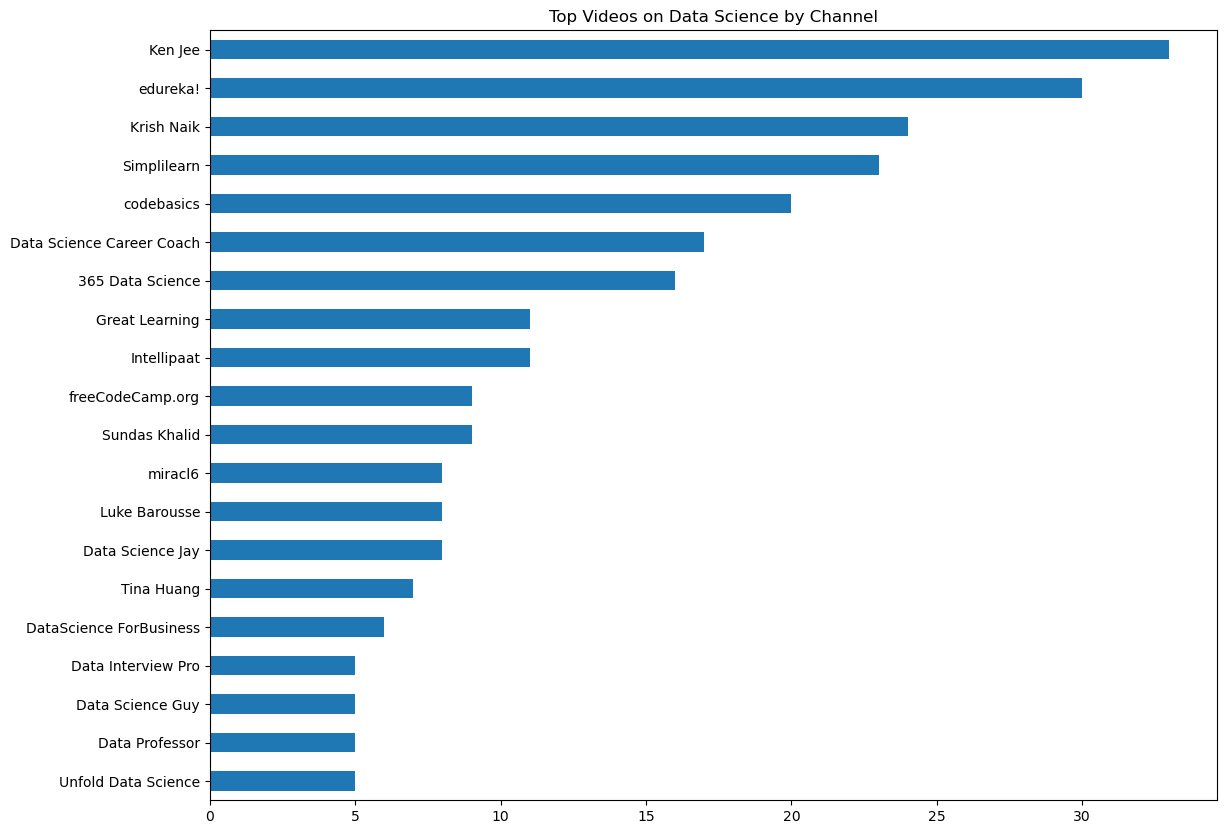

In [61]:
df["channelTitle"].value_counts(ascending=True).tail(20).plot(
    kind="barh", figsize=(13, 10), title="Top Videos on Data Science by Channel"
)

plt.show()

# Get Details of Top Videos

In [57]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


def get_video_stats(df):
    stats = []
    video_ids = [c for c in df["videoId"].unique() if type(c) == str]
    for i in range(0, len(video_ids), 40):
        res = (
            (youtube)
            .videos()
            .list(id=",".join(video_ids[i : i + 40]), part="statistics")
            .execute()
        )
        stats += res["items"]
    stats_df = pd.json_normalize(stats)

    df = df_column_uniquify(df)

    df_all = df.merge(
        stats_df,
        left_on=["videoId"],
        right_on=["id"],
        how="left",
        suffixes=("", "_stats"),
    )
    df_all["statistics.viewCount"] = pd.to_numeric(df_all["statistics.viewCount"])
    df_all["statistics.likeCount"] = pd.to_numeric(df_all["statistics.likeCount"])
    df_all["statistics.commentCount"] = pd.to_numeric(df_all["statistics.commentCount"])
    df_all["statistics.favoriteCount"] = pd.to_numeric(
        df_all["statistics.favoriteCount"]
    )
    return df_all

In [58]:
df_all = get_video_stats(df)

In [90]:
# Dropping bollywood movie.
df_all = df_all.query('id != "c7sfUXT7-qk"').reset_index(drop=True).copy()

df_video_meta = df_all.groupby("channelTitle")[
    [
        "statistics.viewCount",
        "statistics.likeCount",
        "statistics.favoriteCount",
        "statistics.commentCount",
    ]
].sum()
df_video_meta = df_video_meta.astype("int")

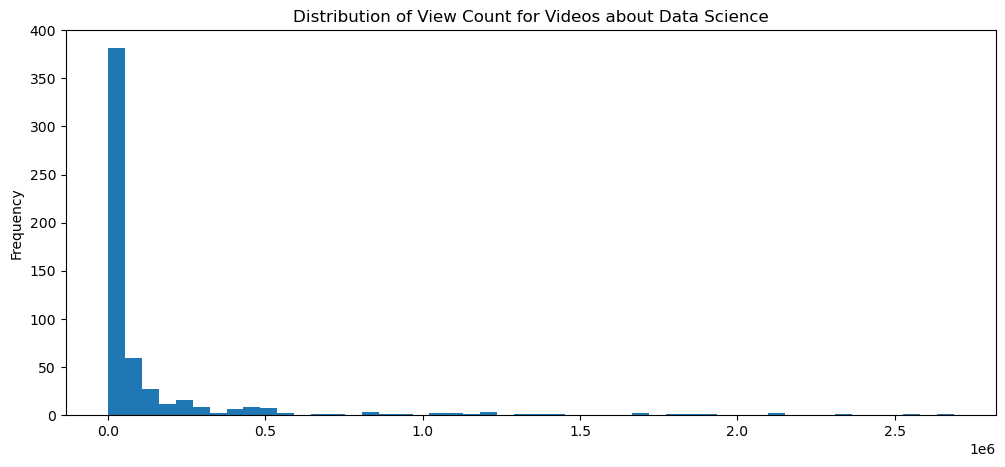

In [93]:
df_all.loc[df_all["statistics.viewCount"] > 1000]["statistics.viewCount"].plot(
    kind="hist",
    bins=50,
    figsize=(12, 5),
    title="Distribution of View Count for Videos about Data Science",
)
plt.show()

In [96]:
# df_all.sort_values("statistics.viewCount", ascending=False)

In [102]:
top_50_channels = (
    df_video_meta.sort_values("statistics.viewCount", ascending=False).head(50).index
)

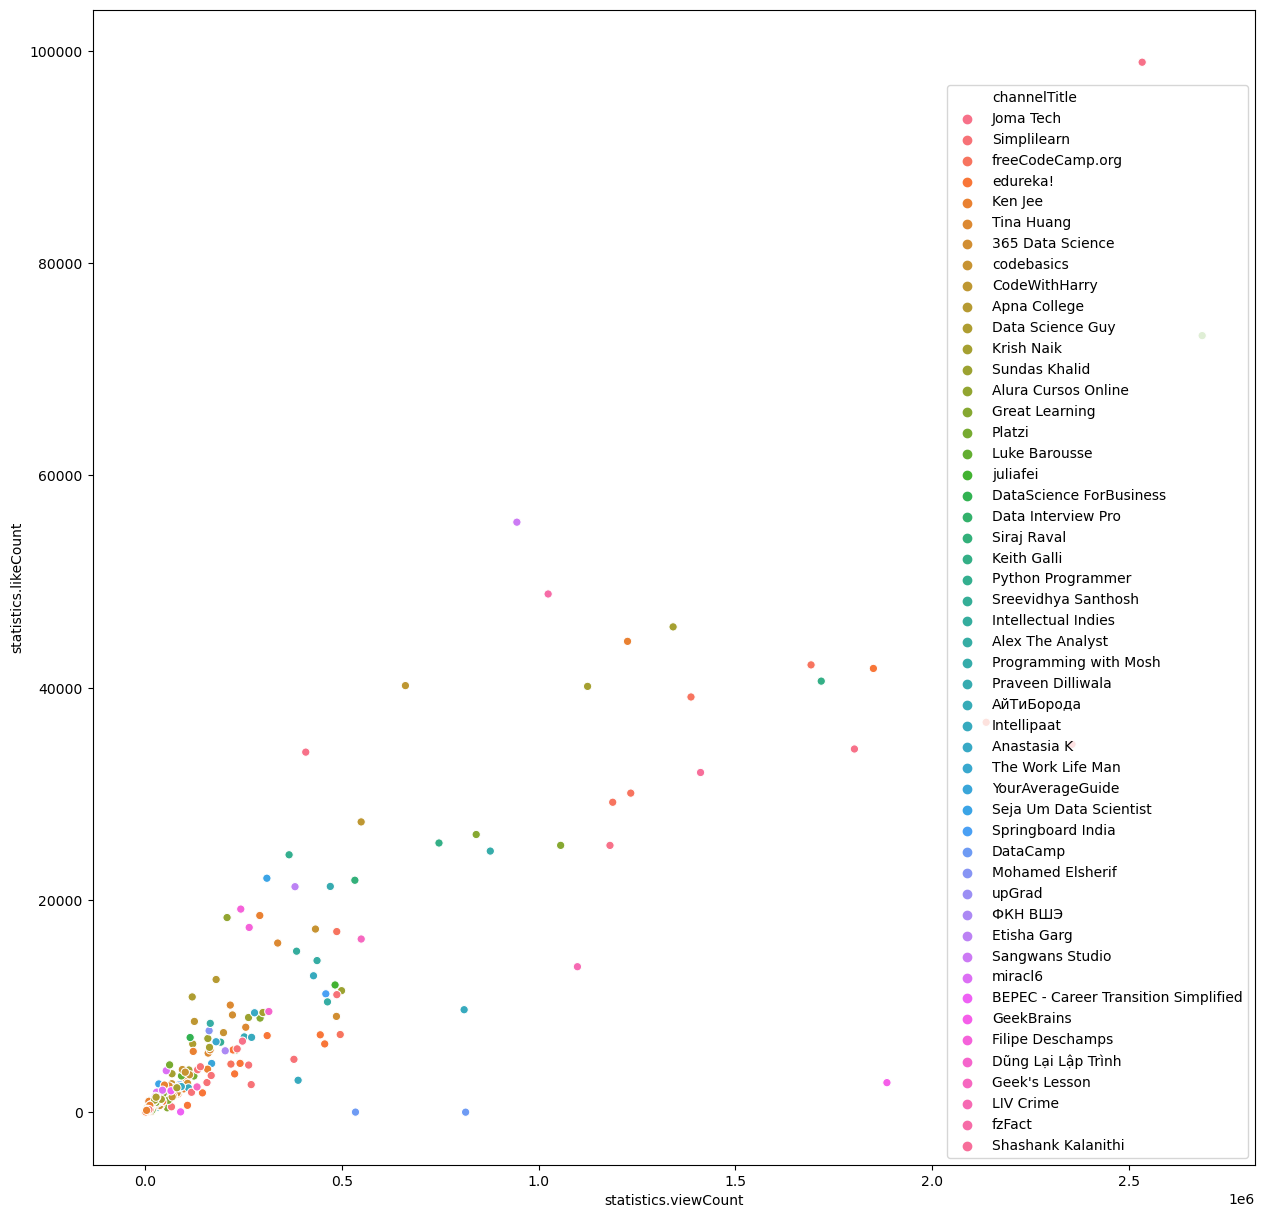

In [107]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(
    x="statistics.viewCount",
    y="statistics.likeCount",
    hue="channelTitle",
    data=df_all.query("channelTitle in @top_50_channels"),
    ax=ax,
)
plt.show()

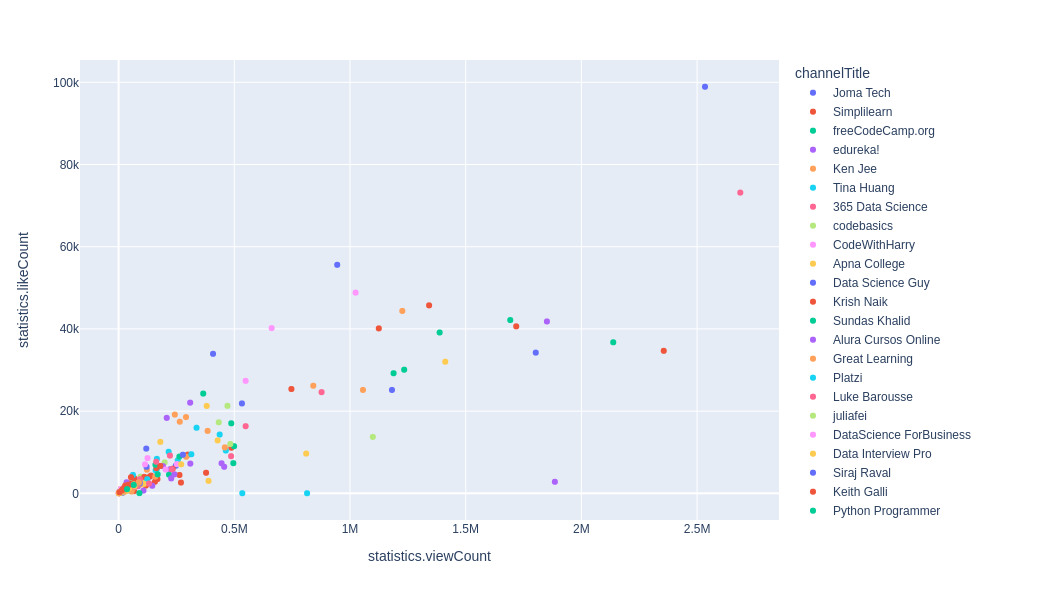

In [123]:
px.scatter(
    data_frame=df_all.query("channelTitle in @top_50_channels"),
    x="statistics.viewCount",
    y="statistics.likeCount",
    color="channelTitle",
    height=600,
    width=1000,
    hover_data=["title"],
)

# Data Engineer Youtube Videos

In [131]:
df_dataeng = get_search_results('"data munging"')
df_all_deng = get_video_stats(df_dataeng)

 45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]


In [133]:
# df_all_deng.sort_values("statistics.viewCount", ascending=False).head(10)

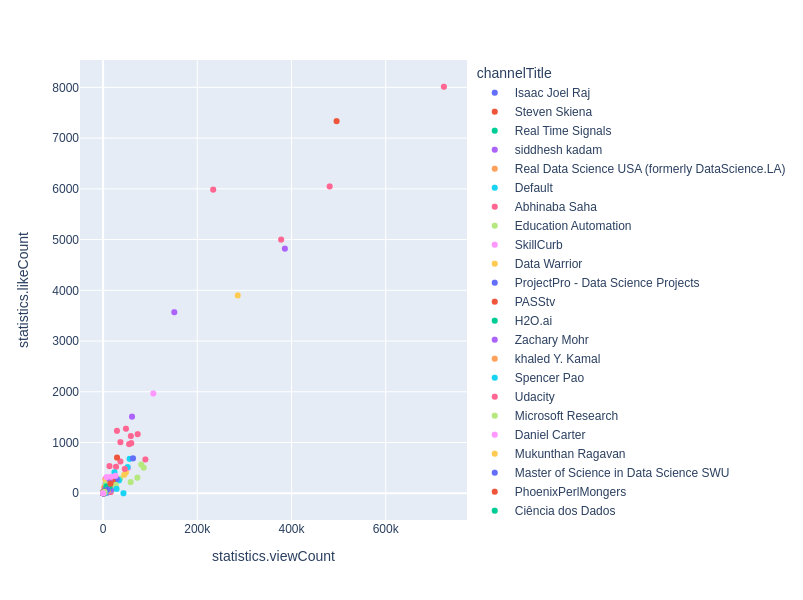

In [134]:
px.scatter(
    data_frame=df_all_deng,
    x="statistics.viewCount",
    y="statistics.likeCount",
    color="channelTitle",
    height=600,
    width=1000,
    hover_data=["title"],
)

# Do the same thing with the search trend "Kaggle"

In [135]:
df_kag = get_search_results("kaggle")
df_all_kag = get_video_stats(df_kag)

 70%|███████   | 14/20 [00:08<00:03,  1.58it/s]


In [137]:
df_all_kag.groupby("channelTitle")["statistics.viewCount"].sum().sort_values(
    ascending=False
).head(50)

channelTitle
Nat and Essie                    4727516.0
Krish Naik                       2829388.0
Ken Jee                          1989923.0
Kaggle                           1736587.0
sentdex                          1127521.0
Siraj Raval                      1042141.0
Programming with Mosh             877197.0
codebasics                        505044.0
Abhishek Thakur                   428634.0
Google Cloud Tech                 355513.0
Tina Huang                        336780.0
Data Science Dojo                 173570.0
AI Journal                        166950.0
Magic Land Telugu Stories         125479.0
Python Programmer                 120640.0
조코딩 JoCoding                      115451.0
NYC Data Science Academy          110467.0
Divya Thakur                       94607.0
Minsuk Heo 허민석                     90333.0
Флесс                              82642.0
Daniel Bourke                      79518.0
Coding Tech                        67590.0
Takami Sato                        60052.